# Ensaio sobre o modelo Long short-term memory (LSTM)

- O principal objetivo é discutir o funcionamento do modelo LSTM com um exemplo prático 
- Também estabelecemos a criação de um arquivo DockerFile

O modelo LSTM (Long Short-Term Memory) é uma rede neural recorrente proposta por [Hochreiter e Schmidhuber](https://papers.baulab.info/Hochreiter-1997.pdf) em 1997. O modelo possui unidades de memória capazes de aprender e esquecer informações por longos períodos. Estas são gerenciadas por portões que controlam o fluxo de informações na camada (ou neurônio/células). Esses mecanismos permitem que a LSTM lide com sequências não estacionárias por exemplo - o que é muito comum em processos estocásticos na natureza.

Essa rede neural veio com a proposta de resolver o problema do desaparecimento de gradiente, que ocorre ao atualizar os pesos das camadas durante um processo de treinamento, no qual os valores tornam-se tão pequenos que não causam mudanças significativas nos pesos propagados de camada em camada.


A seguir temos uma representação esquemática de uma camada LSTM, adaptado do site [Pluralsight](https://www.pluralsight.com/guides/introduction-to-lstm-units-in-rnn) que retirou as imagens do artigo de [Kamilya Smagulova & Alex Pappachen James](https://link.springer.com/chapter/10.1007/978-3-030-14524-8_11).

<div style="width: 50%">
    <img src="https://raw.githubusercontent.com/ander-son-almeida/EnsaioLSTM/master/img/img1.JPG" />
</div>

Veja na imagem acima que a célula foi dividida em quatro regiões com linhas pontilhadas: portão de esquecimento (azul), portão de entrada (laranja), portão de saída (verde) e um estado de célula (cinza).

<div style="width: 55%">
    <img src="https://raw.githubusercontent.com/ander-son-almeida/EnsaioLSTM/master/img/img2.JPG" />
</div>

O papel principal do portão de esquecimento (forget gate) é decidir quais informações precisam de atenção e quais podem ser ignoradas. Este processo pode ser visualizado com as informações da entrada atual $X_t$ e do estado oculto $h_{t-1}$ (também chamado de estado latente ou estado interno), sendo este um vetor numérico que contém informações resumidas sobre o histórico de entradas da rede neural em um determinado momento. 

Desta configuração, as informações são passadas para uma função de ativação, em que, comumente, se usa a função [sigmoide](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_sigmoide), que gera valores entre 0 e 1. Esta função vai decidir se parte da saída antiga é relevante ou não (quanto mais próximo de 1, mais relevante ela é). Assim, a saída devolverá um valor $f_t$ que será posteriormente usado pela célula para uma multiplicação ponto a ponto.

<div style="width: 55%">
    <img src="https://raw.githubusercontent.com/ander-son-almeida/EnsaioLSTM/master/img/img3.JPG" />
</div>

Em sequência, o estado atual $X_t$ e o estado anteriormente oculto $h_t-1$ são passados para uma segunda função sigmoide e esses valores são transformados entre 0 e 1 novamente, gerando o vetor de entrada $i_t$. Em seguida, as mesmas informações do estado oculto e do estado atual são passadas através da função [tanh](https://pt.wikipedia.org/wiki/Tangente_hiperb%C3%B3lica) para regular a rede. Desta forma, o operador tanh criará um vetor $C_t$ com todos os valores possíveis entre -1 e 1. E Assim, os valores de saída gerados pelas funções de ativação estão prontos para multiplicação ponto a ponto.


<div style="width: 55%">
    <img src="https://raw.githubusercontent.com/ander-son-almeida/EnsaioLSTM/master/img/img4.JPG" />
</div>

Agora a rede tem informações suficientes do portão de esquecimento e do portão de entrada. A próxima etapa é decidir e armazenar as informações do novo estado no estado da célula. O estado da célula anterior $C_t-1$ é multiplicado pelo vetor de esquecimento $f_t$. Se o resultado for 0, os valores serão descartados no estado da célula. Em seguida, a rede pega o valor de saída do vetor de entrada $i_t$ e executa a adição ponto a ponto, que atualiza o estado da célula, dando à rede um novo estado de célula $C_t$.

<div style="width: 55%">
    <img src="https://raw.githubusercontent.com/ander-son-almeida/EnsaioLSTM/master/img/img5.JPG" />
</div>

Com o estado atualizado, o portão de saída determina o valor do próximo estado oculto. Primeiro, os valores do estado atual e do estado oculto anterior são passados para uma terceira função sigmoide. Logo, o novo estado da célula gerado é passado através da função tanh. Ambas as saídas são multiplicadas ponto a ponto. Com base no valor final, a rede decide quais informações o estado oculto deve carregar. Inclusive, esse estado oculto é usado para realizar a previsão.

Finalmente, o novo estado da célula e o novo estado oculto são transferidos para a próxima etapa de tempo.


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import Timedelta
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

Em nosso trabalho utilizaremos a biblioteca Keras que possui um código de redes nerais baseado no modelo LSTM, que nos permite construir rapidamente modelos recorrentes sem ter fazer configurações muito complexas. Para mais informações acesse o link: https://keras.io/guides/working_with_rnns/.


Um exemplo clássico do uso de redes neurais, é sua aplicação em séries temporais e estocásticas como os preços de fechamentos de ações. Para essa atividade nos concentraremos em prever uma janela de 15 minutos (window_size) em um dia de negociações. Para isso, temos como base de treinamento para o modelo um histórico dos fechamentos minuto a minuto do ativo PETR3. 


Sendo assim, lemos o dataset (arquivo .npy) fornecido juntamento do código. Não esqueça de alterar o local do arquivo para uma execução local, ou se preferir apenas monte a imagem docker com o arquivo Dockerfile fornecido.

In [23]:
# defini o tamanho da janela e o horizonte de previsão do modelo
window_size = 15 #janela de referencia para treinar o modelo, será o número que vamos "picar" o dataset
horizon = 15 #estou usando essa variavel para representa o horizonte  ou tamanho de pontos que vamos prever. No caso, 15 minutos

In [24]:
history = np.load('S:\Área de Trabalho\EnsaioLSTM\PETR3.npy')
history =  pd.DataFrame(history) #convertendo em dataframe
history = history.set_index('datetime') #fixando a coluna datetime como index

Um diferencial deste código, é que pretendemos fornecer um backtest para avaliar a acurácia do modelo. Para isso, iremos realizar um corte no dataset, para o modelo treinar até um horário limite, por exemplo, até às 14 horas do último dia e tente prever os próximos 15 minutos subsequentes a este horário. 

In [1]:
horario_limite = 14 #horas

In [26]:
# obter o índice do último dia
ultimo_dia = history.index.date[-1]
mask_ultimo_dia = (history.index.date == ultimo_dia) & (history.index.hour < horario_limite)

# criar uma máscara booleana para todos os dias, exceto o último dia
mask_outros_dias = history.index.date < ultimo_dia

# combinar as duas máscaras booleanas 
mask = mask_ultimo_dia | mask_outros_dias

# aplicando a mascara
history_cut = history.loc[mask]

Para prosseguir, precisamos realizar a normalização dos valores para uma escala em comum, para isso estou utilizando o valor 100.

In [27]:
# normalizar o historico 
scaled_data = (history['Close']/100).values

In [28]:
# criar os dados de treinamento e teste
X_train, y_train = [], []
for i in range(window_size, len(scaled_data) - horizon):
    X_train.append(scaled_data[i-window_size:i]) 
    y_train.append(scaled_data[i:i+horizon]) #
X_train, y_train = np.array(X_train), np.array(y_train)

Com o dataset organizado, estamos prontos para dividi-lo e realizar o treinamento do modelo. 

A primeira parte na linha 4, scaled_data[i-window_size:i], corresponde a um conjunto de dados de entrada com um tamanho definido pelo parâmetro window_size. Cada janela desse conjunto é usada como entrada para a rede LSTM em cada passo de tempo.

A segunda parte na linha 5, scaled_data[i:i+horizon], corresponde ao valor esperado de saída para a rede LSTM. Esse valor é o próximo valor que a série temporal deve assumir após a janela de entrada.

In [29]:
# remodelar os dados de treinamento  
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

O formato da matriz é (15, 1), indicando que há 15 elementos na matriz e cada elemento tem uma dimensão única. Cada elemento representa uma observação ou valor em uma série temporal. Este formato geralmente é usado em um modelo de rede neural recorrente.

In [30]:
# criando o modelo
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mean_squared_error')

Nosso modelo de redes neurais vai assumir a seguinte arquitetura:

- A primeira camada LSTM tem 50 células e return_sequences=True, o que significa que retorna as sequências completas de saída para cada etapa de tempo, em vez de apenas a saída final. A função ativação não foi especificada, mas no caso do Keras é a função hiperbólica (tang).



- A segunda camada LSTM também tem 50 células. Essa camada recebe como entrada a saída da primeira camada LSTM, que tem return_sequences=True, ou seja, retorna a sequência completa de saídas de todas as unidades da camada anterior, em vez de retornar somente a última saída da sequência.



- A camada densa tem o número de unidades especificado pela variável horizon, que determina quantos valores a rede deve prever no futuro, baseada nas informações processadas pelas camadas anteriores.



- A função de ativação padrão para a camada densa é a [função linear retificada (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). A principal diferença da camada densa em relação às camadas LSTM é que a camada densa é uma camada totalmente conectada, onde cada unidade está conectada a todas as unidades da camada anterior. Enquanto as camadas LSTM são comumente usadas em tarefas de processamento de sequência, a camada densa é usada para produzir a saída final do modelo, onde cada unidade na camada densa corresponde a uma saída diferente.



- O parâmetro optimizer no Keras recebe um algoritmo de otimização para treinar o modelo. Neste caso, estamos utilizando o "adam" (Adaptive Moment Estimation) que foi publicado por [Diederik P. Kingma e Jimmy Lei Ba em 2014](https://arxiv.org/abs/1412.6980). Este algoritmo consegue adaptar os pesos para cada parâmetro, ajudando a reduzir a complexidade do ajuste do modelo e acelerando a convergência.



- A função de perda utilizada é a 'mean_squared_error', que calcula a média dos erros ao quadrado entre as previsões e as saídas esperadas. O objetivo é minimizar essa função de perda, ou seja, fazer com que o erro entre as previsões e as saídas esperadas seja o menor possível.

In [31]:
# treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
2856/2856 [==============================] - 25s 8ms/step - loss: 4.0902e-04
Epoch 2/10
2856/2856 [==============================] - 21s 7ms/step - loss: 7.2490e-06
Epoch 3/10
2856/2856 [==============================] - 21s 7ms/step - loss: 7.2473e-06
Epoch 4/10
2856/2856 [==============================] - 21s 7ms/step - loss: 6.5183e-06
Epoch 5/10
2856/2856 [==============================] - 21s 7ms/step - loss: 5.7421e-06
Epoch 6/10
2856/2856 [==============================] - 22s 8ms/step - loss: 5.5553e-06
Epoch 7/10
2856/2856 [==============================] - 21s 7ms/step - loss: 4.9942e-06
Epoch 8/10
2856/2856 [==============================] - 21s 7ms/step - loss: 4.8421e-06
Epoch 9/10
2856/2856 [==============================] - 21s 7ms/step - loss: 4.2868e-06
Epoch 10/10
2856/2856 [==============================] - 21s 7ms/step - loss: 4.1363e-06


Uma época (epoch) refere-se a uma passagem pelo conjunto completo dos dados de treinamento durante o processo de treinamento. Durante uma época, todos os dados de treinamento são apresentados ao modelo uma vez, em lotes (batches), para que o modelo possa ajustar seus pesos e atualizar suas estimativas.

O treinamento de um modelo é geralmente dividido em várias épocas, e em cada época o modelo tenta melhorar a qualidade de suas previsões ajustando seus pesos. Cada época consiste em vários passos, onde um passo é um único processamento de um lote de dados. O número de épocas necessárias para treinar um modelo depende do problema em questão, do tamanho e complexidade do conjunto de dados, para este exemplo fixamos 10 épocas para não estender o tempo de treinamento. 

O número de épocas é um hiperparâmetro que deve ser ajustado cuidadosamente durante o processo de treinamento. Se o número de épocas for muito baixo, o modelo pode não ter tempo suficiente para aprender os padrões presentes nos dados de treinamento. Por outro lado, se o número de épocas for muito alto, o modelo pode começar a aprender os dados de treinamento de cor e apresentar overfitting, ou seja, o modelo aprende demasiadamente os dados de treinamento e não consegue generalizar para novos dados. Portanto, encontrar um equilíbrio adequado é crucial para obter um modelo preciso.

In [32]:
# realizando a previsao

last_window = scaled_data[-window_size:].reshape((1, window_size, 1))
prediction = model.predict(last_window).reshape((horizon,))

# criar o índice de datas para as previsões
last_date = pd.to_datetime(history_cut.index[-1])
dates = pd.date_range(last_date + pd.Timedelta(minutes=1), periods=horizon, freq='T')

# criar o DataFrame com as previsões
predictions_df = pd.DataFrame({'Close': prediction}, index=dates)

1/1 [==============================] - 1s 595ms/step


Enfim realizando a previsão. Na linha 3 estamos pegando os últimos 15 minutos do dateset e armazenando na variável "last_window" para realizar a previsão neste último padrão que esta se apresentando. O formato do conjunto de dados é ajustado para uma matriz 3D com dimensões (1, window_size, 1).

Na linha 4, o modelo é utilizado para prever os próximos 15 valores com base no last_window mencionado. A saída da previsão é uma matriz 2D com dimensões (1, horizon, 1), por isso usamos a função reshape para transformar essa matriz em um vetor unidimensional com 15 elementos.

Em seguida na linha 7, 8 e 11 utilizamos o pandas para criar um Dataframe com os valores da previsão e fixando um index com as datas e horário da previsão.

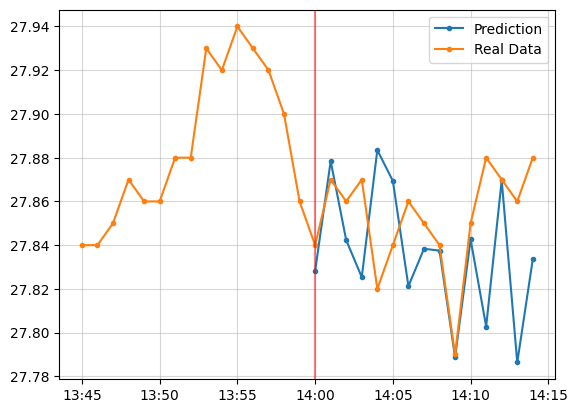

In [72]:
# grafico

fig, ax = plt.subplots()
plt.plot((predictions_df*100)*1.005, marker='.', label='Prediction')

ind = ((history.index >= predictions_df.index[0] - Timedelta(minutes=horizon)) & 
        (history.index <= predictions_df.index[-1]))

ax.plot(history['Close'][ind], marker='.', label='Real Data')
ax.axvline((predictions_df.index)[0], color = 'r',alpha=0.5)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
plt.grid(alpha=0.5)

plt.legend()


Por fim, construímos um gráfico no qual nos concentramos apenas em avaliar o quão próximo à curva de previsão se aproxima da curva real visualmente. De certa forma, os resultados são satisfatórios apesar de ter errado na escala e tivemos que multiplicar por uma constante. Nota-se que ruído é trazido juntamente da previsão e o sentido da variação estocástica segue de forma semelhante.